# 0.0. IMPORTS

In [290]:
import inflection
import warnings

import pandas      as pd
import numpy       as np
import seaborn     as sns
import umap.umap_  as umap
import regex       as re
import scipy.stats as st

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pandas_profiling    import ProfileReport

from matplotlib          import pyplot        as plt
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from plotly              import express       as px
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import manifold      as mn
from sklearn             import mixture       as mx
from sklearn             import ensemble      as en
from scipy.cluster       import hierarchy     as hc

# hide warnings
warnings.filterwarnings("ignore")

## 0.1. Aux Functions

In [173]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24

#     display(HTML('<style>.container { width:100% !important; }</style>'))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.options.display.float_format = '{:,.4f}'.format
#     pd.set_option('display.expand_frame_repr', False)
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Data Collection

In [174]:
# reading data
df = pd.read_csv( "../datasets/Ecommerce.csv", encoding='unicode_escape' )

# removing unnamed column
df = df.drop( columns=['Unnamed: 8'] )

# 1.0. DATA DESCRIPTION

In [175]:
df1 = df.copy()

## 1.1. Columns Description

In [176]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

- **InvoiceNo**: Invoice number (A 6-digit integral number uniquely assigned to each transaction)

- **StockCode**: Product code

- **Description**: Product name

- **Quantity**: The quantities of each product per transaction

- **InvoiceDate**: The day when each transaction was generated

- **UnitPrice**: Product price per unit

- **CustomerID**: Customer number (Unique ID assigned to each customer)

- **Country**: Country name (The name of the country where each customer resides)

### 1.1.1. Rename columns

In [177]:
cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
        'UnitPrice', 'CustomerID', 'Country']

# camelcase cols to snakecase
snakecase = lambda x: inflection.underscore( x )
new_cols = list( map( snakecase , cols ) )
new_cols

# renaming cols
df1.columns = new_cols

## 1.2. Data Dimensions

In [178]:
print( f'Number of rows: { df1.shape[0]}' )
print( f'Number of columns: { df1.shape[1]}' )

Number of rows: 541909
Number of columns: 8


## 1.3. NA check

In [179]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.3.1. Na Fullfill

In [180]:
# separate missing and non missing customer id datasets
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[~df1['customer_id'].isna()]

# create new id based on grouped invoice number of the missing ones
df_missing_invoice_numbers = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_missing_invoice_numbers['customer_id'] = np.arange( 19000, 19000 + len( df_missing_invoice_numbers ), 1 )

# merge df1 with new dataset without customer id na's
df1 = pd.merge( df1, df_missing_invoice_numbers, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop customer id x and y
df1 = df1.drop( columns=['customer_id_x','customer_id_y'], axis=1 )

## 1.4. Data Types

In [181]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

### 1.4.1. Change data types

In [182]:
# customer_id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

## 1.5. Descriptive Statistics

In [183]:
df_num = df1[['quantity','unit_price']]
df_cat = df1.select_dtypes( exclude=['float64','int64','datetime64[ns]'] )

### 1.5.1. Numerical Attributes

In [184]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# central tendency - mean, median
ct1 = pd.DataFrame( df_num.apply( lambda x: np.mean( x ) ) ).T
ct2 = pd.DataFrame( df_num.apply( lambda x: np.median( x ) ) ).T

# dispersion metrics - min, max, range, std, skewness, kurtosis
dm1 = pd.DataFrame( df_num.apply( lambda x: np.min( x ) ) ).T
dm2 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) ) ).T
dm3 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) - np.min( x ) ) ).T
dm4 = pd.DataFrame( df_num.apply( lambda x: np.std( x ) ) ).T
dm5 = pd.DataFrame( df_num.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( df_num.apply( lambda x: x.kurtosis() ) ).T

# concat
df_descriptive = pd.concat( [ dm1, dm2, dm3, ct1, ct2, dm4, dm5, dm6 ] ).T
df_descriptive.columns = ( 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis' )
df_descriptive

,min,max,range,mean,median,std,skewness,kurtosis
quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72


#### Problems

- Negative **quantity**

- High value **quantity** ( 80995 )

- **unit_price** = 0

- Negative **unit_price**

### 1.5.2. Categorical Attributes

#### invoice_no ( should be int )

In [185]:
#df_cat['invoice_no'].astype( 'int64' )
invoice_no_with_strings = len(df_cat.loc[df_cat['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'] )
print( f'Invoice number with strings: {invoice_no_with_strings}' )

Invoice number with strings: 9291


#### stock_code ( should be int )

In [186]:
stock_code_with_strings = len(df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'stock_code'].drop_duplicates() )
print( f'Stock code with strings: {stock_code_with_strings}' )

Stock code with strings: 1124


In [187]:
df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
#df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), :].head()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [188]:
len(df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'])

2759

#### description

In [189]:
df_cat.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### country

In [190]:
df_cat['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [191]:
df_cat['country'].value_counts( normalize=True ).head()

United Kingdom   0.91
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.00
Name: country, dtype: float64

In [192]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values( 'customer_id', ascending=False ).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


#### Problems

- **Invoice number** with strings

- **Stock code** with strings

- **Stock code** only with strings: 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'

- Useless feature **'description'**

# 2.0. DATA FILTERING

In [193]:
df2 = df1.copy()

In [194]:
# description
df2 = df2.drop( columns=['description'] ) # Useless feature 'description'

# unit_price
df2 = df2[df2['unit_price'] >= 0.04] # unit_price = 0

# stock code
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']) ] # Stock code only with strings: 'POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'...

# country 
df2 = df2[~df2['country'].isin( ['European Community','Unspecified'] ) ] # google latitudes

# quantity
df_return = df2[ df2['quantity'] < 0 ] # quantity < 0
df_purchase = df2[ df2['quantity'] >=0 ]

In [195]:
perc_lost = 100 * ( df_return.shape[0] / ( df_return.shape[0] + df_purchase.shape[0] ) )
print( 'Lost {:.2f}% of database with separating df return and purchase'.format( perc_lost ) ) 

Lost 1.63% of database with separating df return and purchase


# 3.0. FEATURE ENGINEERING

In [196]:
df3 = df2.copy()

In [197]:
# aux df
df_aux = df3[['customer_id']].drop_duplicates( ignore_index=True )

## Recency ( days since last purchase )

In [198]:
df_recency = df3[['invoice_date','customer_id']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop( columns=['invoice_date'] )
df_aux = pd.merge( df_aux, df_recency, on='customer_id', how='left' )

## Average Recency 

In [199]:
df_customer_ordered = df3[['customer_id','invoice_date']].drop_duplicates().sort_values( ['customer_id','invoice_date'], ascending=[False,False] )
df_customer_ordered['next_customer_id'] = df_customer_ordered['customer_id'].shift() # next customer
df_customer_ordered['next_date'] = df_customer_ordered['invoice_date'].shift() # next date

df_customer_ordered['avg_recency'] = df_customer_ordered.apply( lambda x: x['next_date'] - x['invoice_date'] 
                                                                if x['customer_id'] == x['next_customer_id'] 
                                                                else np.nan, axis=1 )

df_customer_ordered['avg_recency'] = df_customer_ordered['avg_recency'].dt.days
df_customer_ordered = df_customer_ordered.drop( columns=['invoice_date','next_customer_id','next_date'] )
df_customer_ordered_grouped = df_customer_ordered.groupby( 'customer_id' ).mean().reset_index()
df_aux = pd.merge( df_aux, df_customer_ordered_grouped, on='customer_id', how='left' )

In [200]:
df_aux.isna().sum()

customer_id       0
recency           0
avg_recency    2816
dtype: int64

## Monetary

In [201]:
# monetary per client ( quantity * unit_price )
df3['monetary'] = df3['quantity'] * df3['unit_price']
df_monetary = df3[['customer_id','monetary']].groupby( 'customer_id' ).sum().reset_index()
df_aux = pd.merge( df_aux, df_monetary, on='customer_id', how='left' )

## Average Ticket

In [202]:
df_avg_ticket = df3[['customer_id','monetary']].groupby( 'customer_id' ).mean().rename( columns={'monetary':'average_ticket'} ).reset_index()
df_aux = pd.merge( df_aux, df_avg_ticket, on='customer_id', how='left' )

## Total transactions

In [203]:
df_total_transactions = df3[['customer_id','invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_total_transactions.columns = [ 'customer_id', 'total_transactions' ]
df_aux = pd.merge( df_aux, df_total_transactions, on='customer_id', how='left' )

## Items purchased

In [204]:
df_mean_items = df3[['customer_id','invoice_no','stock_code']].groupby(['customer_id','invoice_no']).count().reset_index()
df_mean_items = df_mean_items[['customer_id','stock_code']].groupby('customer_id').sum().rename( columns={'stock_code':'items_purchased'} ).reset_index()
df_aux = pd.merge( df_aux, df_mean_items, on='customer_id', how='left' )

## Basket size

In [205]:
df_mean_products = df3[['customer_id','invoice_no','quantity']].groupby(['customer_id','invoice_no']).sum().reset_index()
df_mean_products = df_mean_products[['customer_id','quantity']].groupby('customer_id').sum().rename( columns={'quantity':'basket_size'} ).reset_index()
df_aux = pd.merge( df_aux, df_mean_products, on='customer_id', how='left' )

## Number of returns

In [206]:
df_number_returns = df_return[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity':'number_returns'} )
df_aux = pd.merge( df_aux, df_number_returns, on='customer_id', how='left' )
df_aux.loc[df_aux['number_returns'].isna(), 'number_returns' ] = 0
df_aux['number_returns'] = df_aux['number_returns'] * -1

## Frequency

In [207]:
df_frequency = ( df3[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                   .groupby( 'customer_id')
                                                                   .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                         min_ = ( 'invoice_date', 'min' ),
                                                                         days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                         buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_frequency['frequency'] = df_frequency[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_aux = pd.merge( df_aux, df_frequency[['customer_id', 'frequency']], on='customer_id', how='left' )

# 4.0. EXPLORATORY DATA ANALYSIS ( EDA )

In [208]:
df4 = df_aux.dropna()

## 4.1. Univariated Analysis

In [209]:
# profile = ProfileReport( df3 )
# profile.to_file( 'report.html' )

**Report from pandas profiling on notebooks/report.html**

#### 4.1.1. Report Filtering

In [210]:
df4 = df4[ ~(df4['customer_id'] == 16446) ]
df4 = df4[ ~(df4['customer_id'] == 12346) ]

## 4.2. Bivariated Analysis

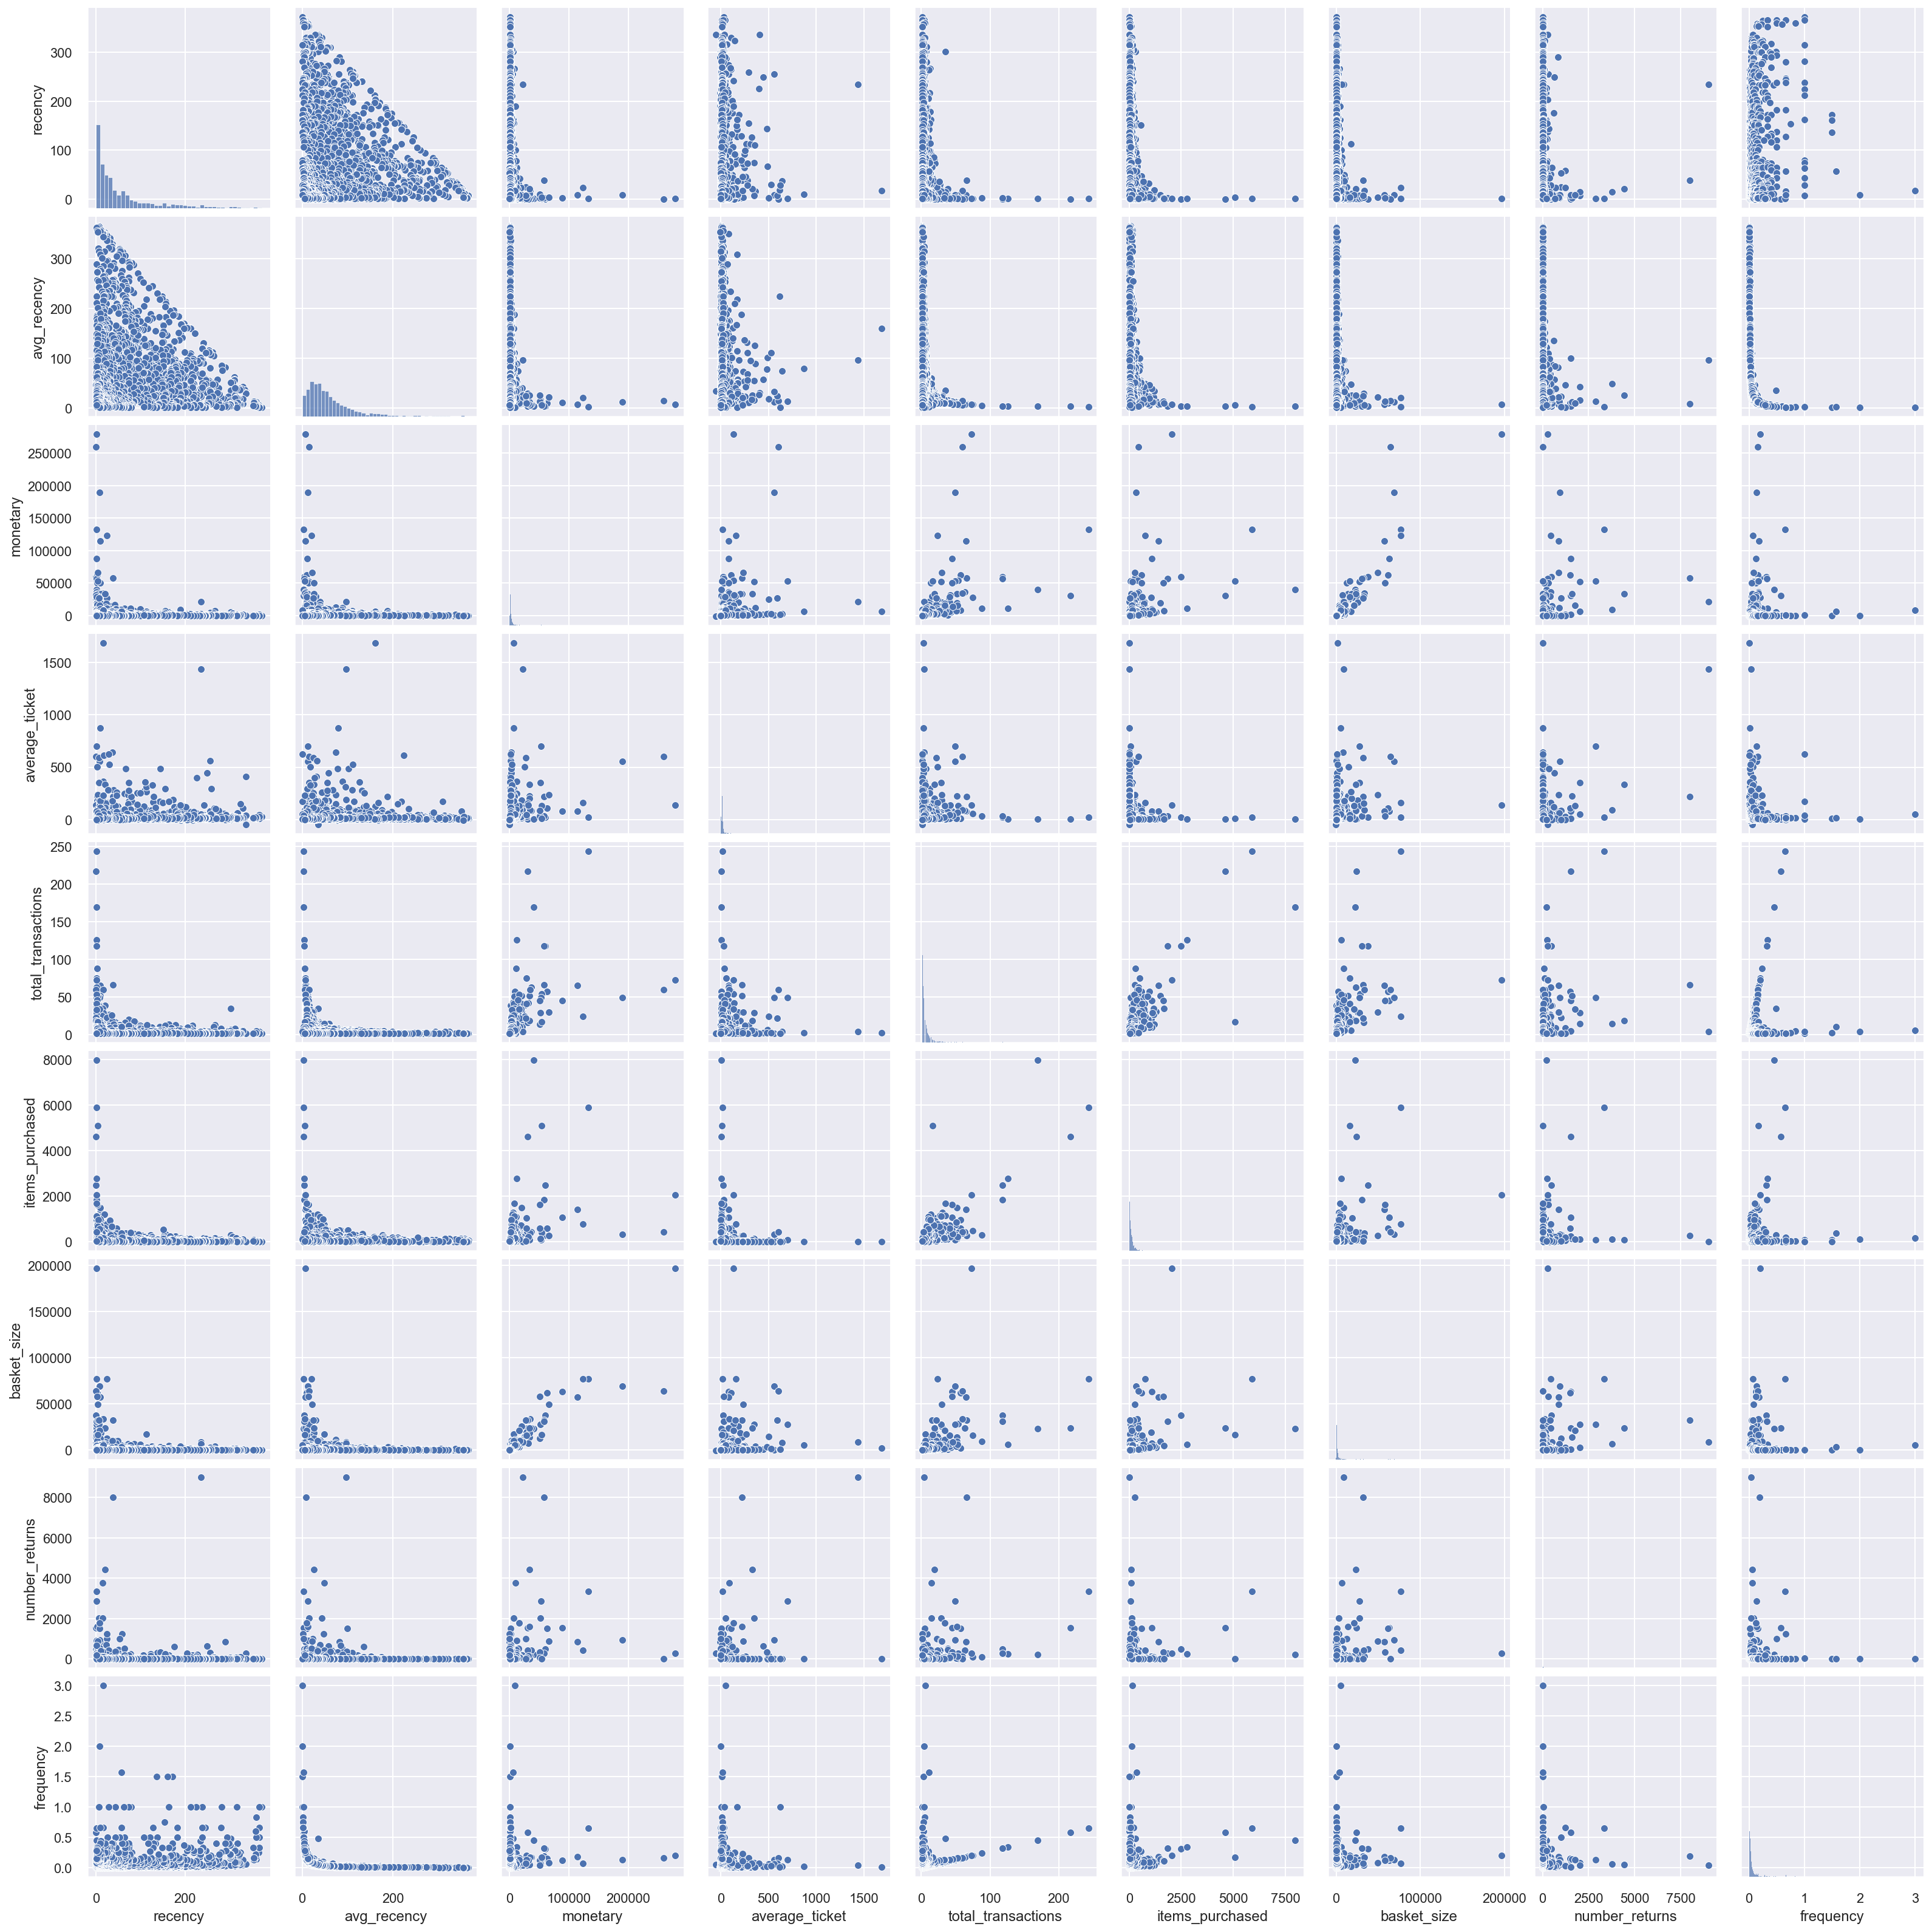

In [211]:
cols = ['customer_id']
df_bivariated = df4.drop( cols, axis=1 )

sns.pairplot( df_bivariated );

## 4.3. Space Study

In [212]:
df_space_study = df4.drop( columns=['customer_id','avg_recency','average_ticket','basket_size'] )

In [213]:
mms = pp.MinMaxScaler()

df_space_study['recency'] = mms.fit_transform( df_space_study[['recency']] )
df_space_study['items_purchased'] = mms.fit_transform( df_space_study[['items_purchased']] )
df_space_study['monetary'] = mms.fit_transform( df_space_study[['monetary']] )
df_space_study['number_returns'] = mms.fit_transform( df_space_study[['number_returns']] )
df_space_study['frequency'] = mms.fit_transform( df_space_study[['frequency']] )
df_space_study['total_transaction'] = mms.fit_transform( df_space_study[['total_transactions']] )

In [214]:
X = df_space_study.copy()

### 4.3.1. PCA

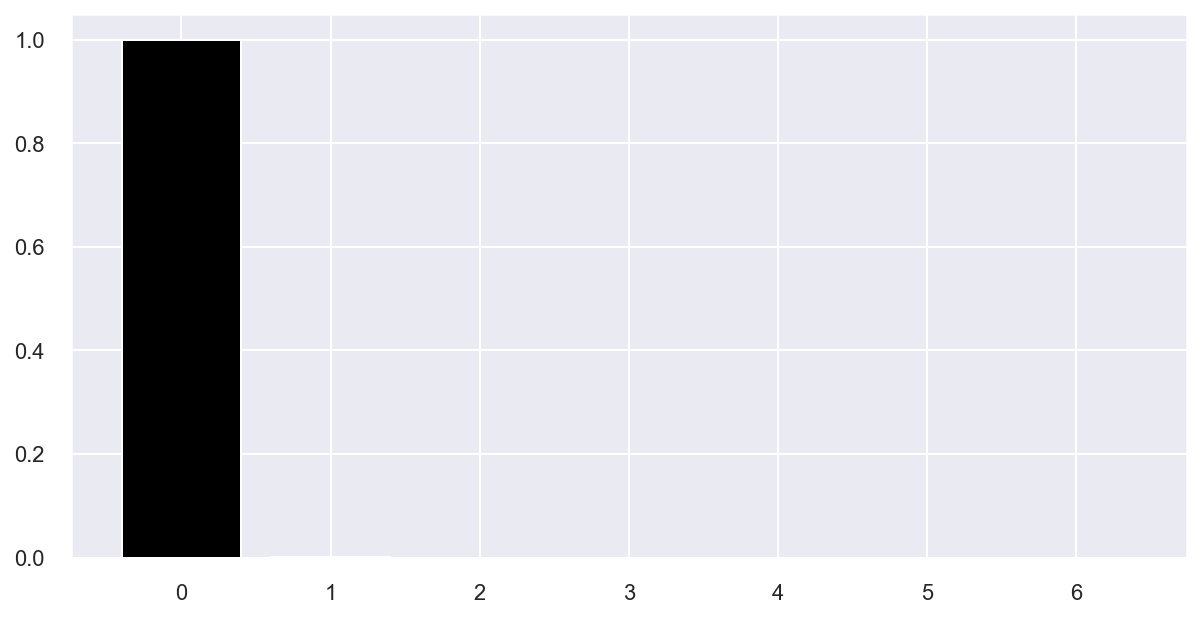

In [215]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

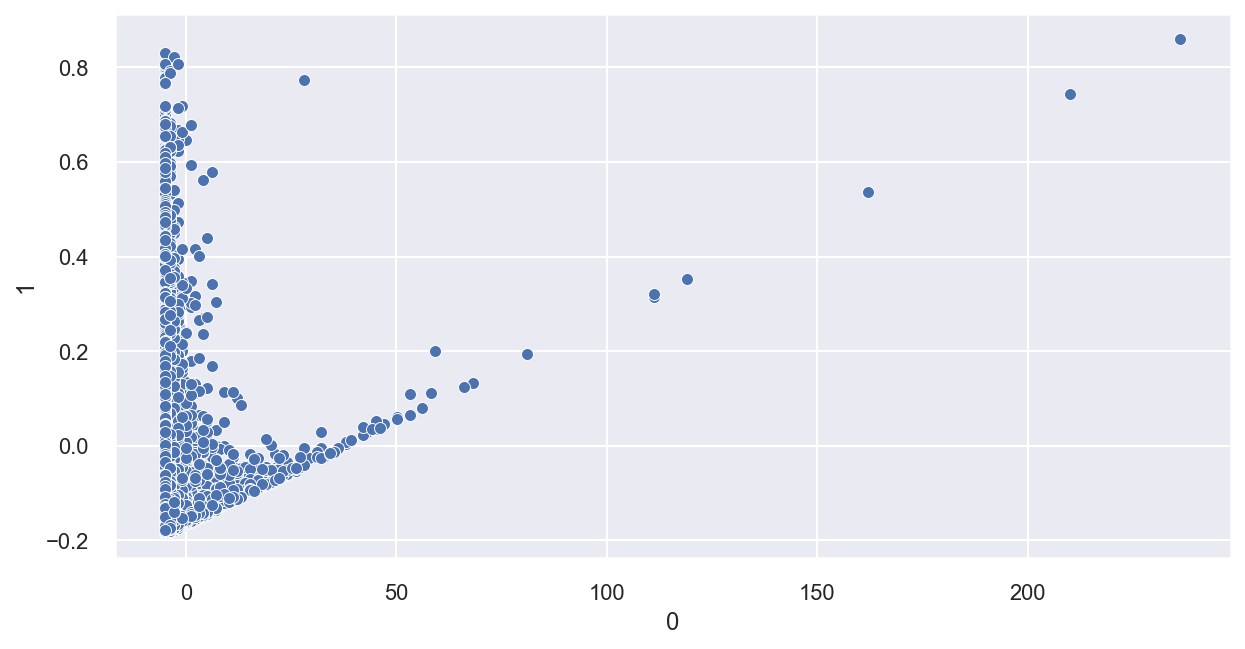

In [216]:
sns.scatterplot( x=0, y=1, data=df_pca );

### 4.3.2. UMAP

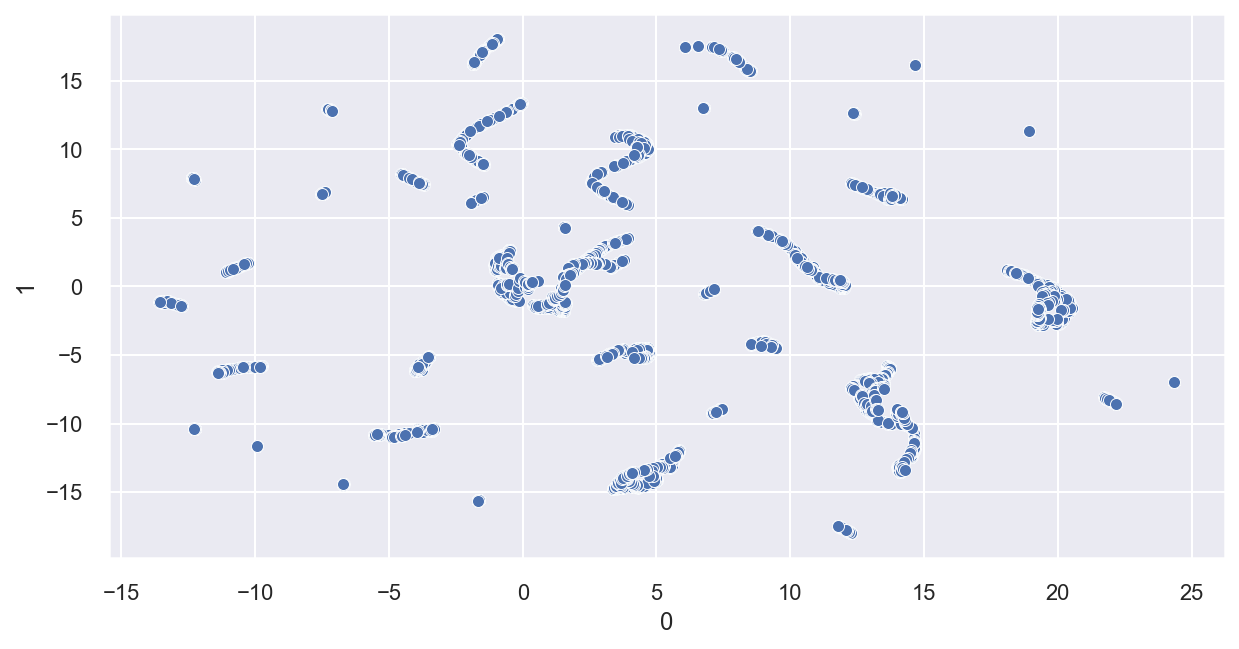

In [217]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding df
df_umap = pd.DataFrame( embedding )

# plot UMAP
sns.scatterplot( x=0, y=1, data=df_umap );

### 4.3.3. t-SNE

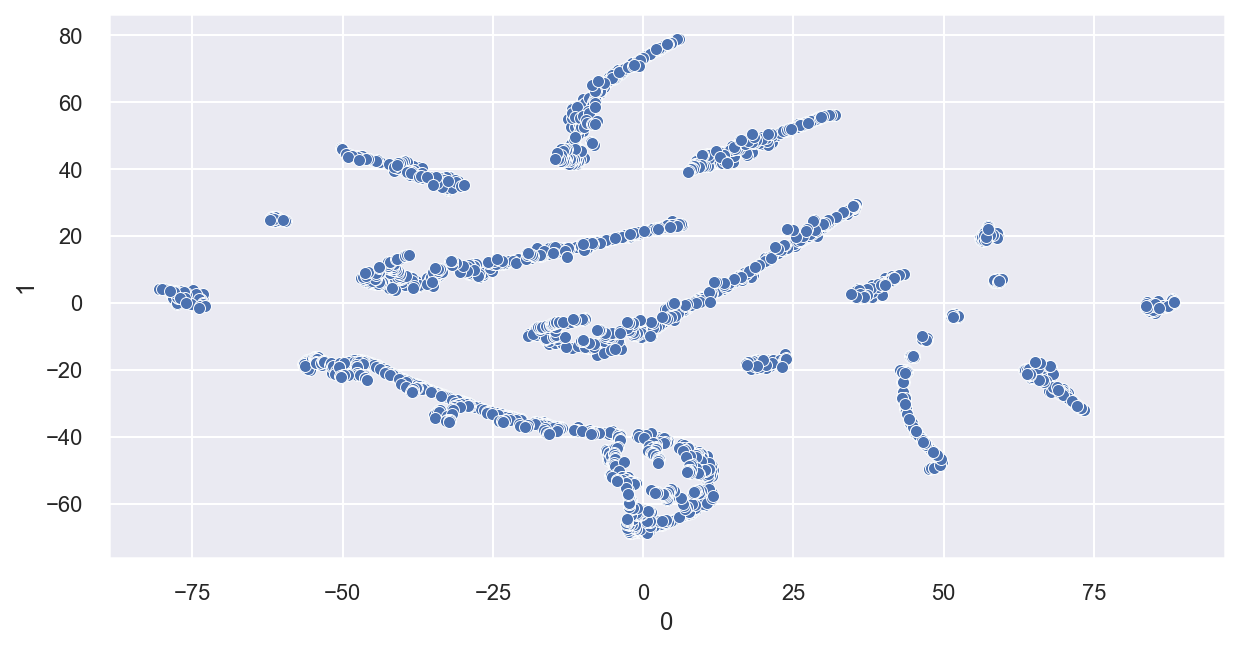

In [218]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding df
df_tsne = pd.DataFrame( embedding )

# plot UMAP
sns.scatterplot( x=0, y=1, data=df_tsne );

### 4.3.4. Tree-Based Embedding

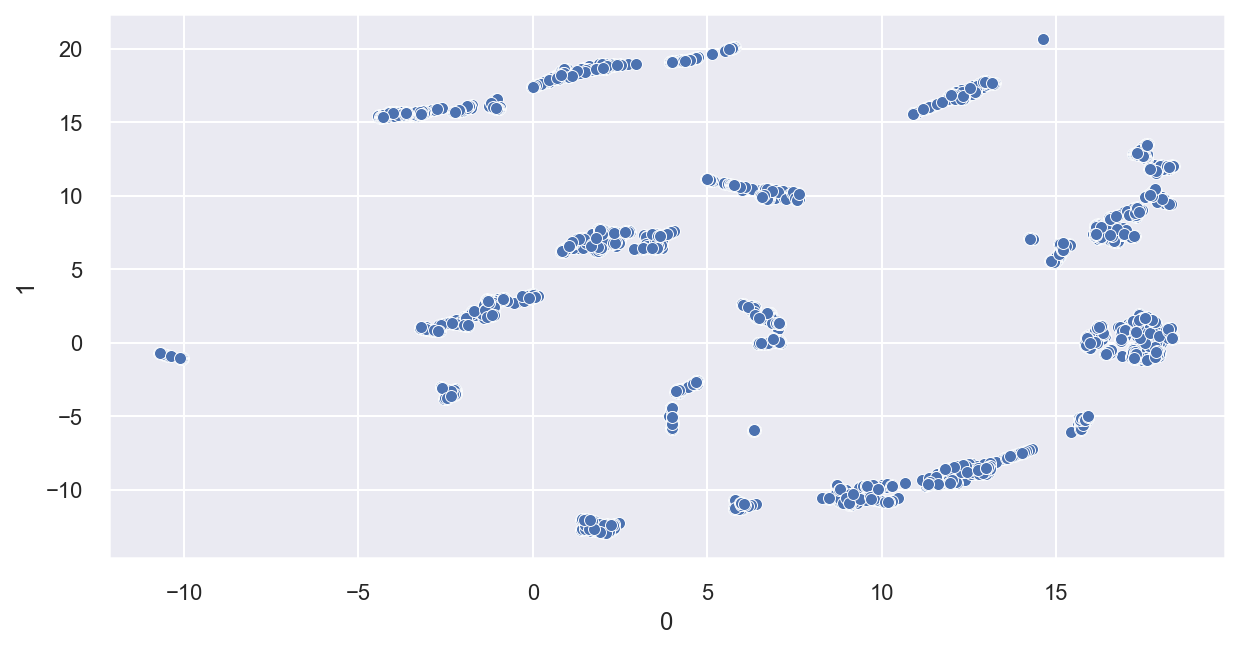

In [219]:
# training dataset
x = df4.drop( columns=['customer_id','monetary' ] )
y = df4['monetary']

# model definition
model = en.RandomForestRegressor( n_estimators=100, random_state=3 )

# model training
model.fit( x, y )

# leaf
df_leaf = pd.DataFrame( model.apply( x ) )

# reducing dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_rf = pd.DataFrame( embedding ) 

# plot UMAP
sns.scatterplot( x=0, y=1, data=df_rf );

# 5.0. DATA PREPARATION

In [220]:
df5 = df4.copy()

## 5.1. Rescaling

In [221]:
mms = pp.MinMaxScaler()

df5['recency'] = mms.fit_transform( df5[['recency']] )
df5['avg_recency'] = mms.fit_transform( df5[['avg_recency']] )
df5['monetary'] = mms.fit_transform( df5[['monetary']] )
df5['average_ticket'] = mms.fit_transform( df5[['average_ticket']] )
df5['total_transactions'] = mms.fit_transform( df5[['total_transactions']] )
df5['items_purchased'] = mms.fit_transform( df5[['items_purchased']] )
df5['basket_size'] = mms.fit_transform( df5[['basket_size']] )
df5['number_returns'] = mms.fit_transform( df5[['number_returns']] )
df5['frequency'] = mms.fit_transform( df5[['frequency']] )

# 6.0. FEATURE SELECTION

In [222]:
cols_selected = [ 'recency', 'monetary', 'items_purchased', 'number_returns', 'frequency', 'total_transactions' ]
df6 = df5[ cols_selected ].copy()

# 7.0. HYPERPARAMETER FINE TUNING

In [223]:
df7 = df6.copy()
#df7 = df7.drop( columns=['customer_id']) 

In [224]:
# k numbers
clusters = [ 2, 3, 4, 5, 6, 7 ]

## 7.1. K-Means

In [225]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans = c.KMeans( n_clusters=k )

    # model training
    kmeans.fit( df7 )

    # model predict
    labels = kmeans.predict( df7 )

    # model performance
    silhouette = m.silhouette_score( df7, labels, metric='euclidean' )
    kmeans_list.append( silhouette )

### 7.1.1. Silhouette Score

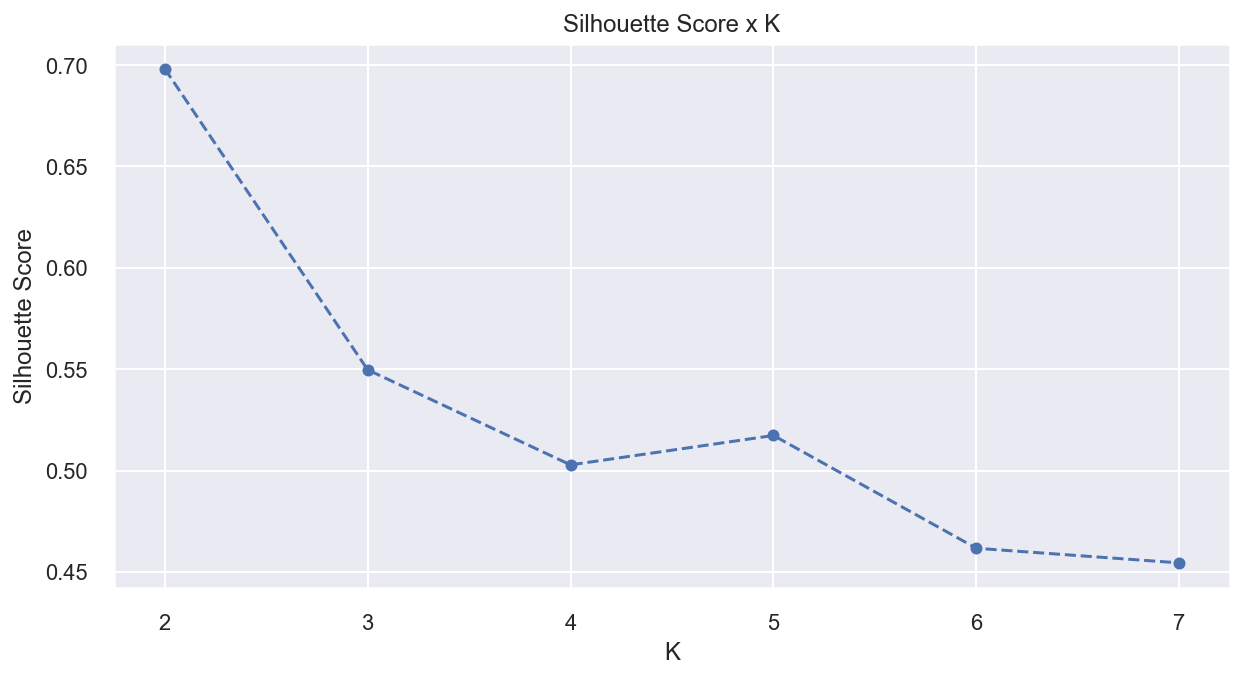

In [226]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [227]:
gmm_list = []

for k in clusters:
    # model definition
    gmm = mx.GaussianMixture( n_components=k )

    # model training
    gmm.fit( df7 )

    # model prediction
    labels = gmm.predict( df7 )

    # model performance
    silhouette = m.silhouette_score( df7, labels, metric='euclidean' )
    gmm_list.append( silhouette )

### 7.2.1. Silhouette Score

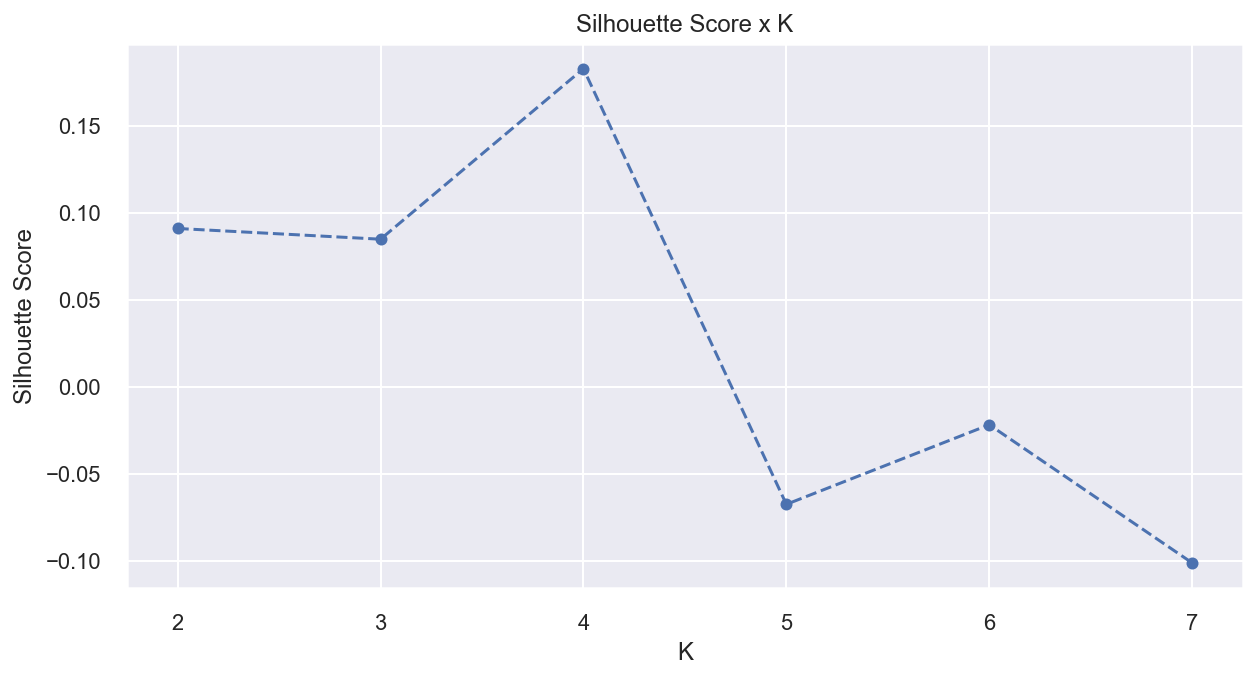

In [228]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K');

## 7.3. Hierarchical Clustering

In [229]:
hc_list = []

for k in clusters:
    # model definition and training
    hc_model = hc.linkage( df7, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    silhouette = m.silhouette_score( df7, labels, metric='euclidean' )
    hc_list.append( silhouette )

### 7.3.1. Silhouette Score

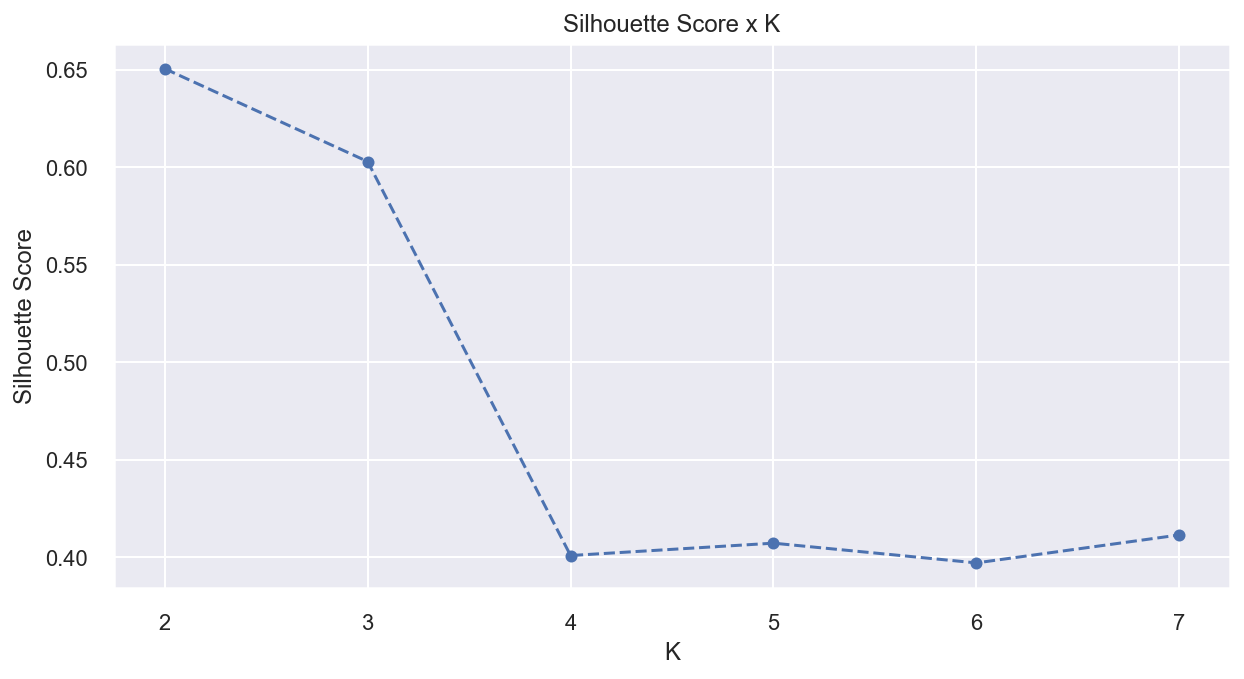

In [230]:
plt.plot( clusters, hc_list, linestyle='--', marker='o' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K');

## 7.4. All Models Performance

In [231]:
models_results = pd.DataFrame( { 'K-Means': kmeans_list,
                                 'GMM': gmm_list,
                                 'HClustering': hc_list } ).T

models_results.columns = clusters
models_results.style.highlight_max( color='lightblue', axis=1 )

,2,3,4,5,6,7
K-Means,0.698222,0.549703,0.502801,0.517310,0.461674,0.454457
GMM,0.090965,0.084807,0.182699,-0.067416,-0.021727,-0.101038
HClustering,0.650665,0.603032,0.400934,0.407276,0.397157,0.411494


# 8.0. FINAL MODEL

In [232]:
df8 = df7.copy()

## 8.1. K-Means

In [233]:
# model definition
k = 5
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( df8 )

# clustering
labels = kmeans.labels_

### WSS and Silhouette Score

In [234]:
# Within-Cluster Sum of Square ( WSS )
print( f'WSS: { kmeans.inertia_ }' )

# Silhouette Score
print( 'Silhouette Score: {}'.format( m.silhouette_score( df8, labels, metric='euclidean' ) ) )

WSS: 23.29284355733678
Silhouette Score: 0.5204226207297652


# 9.0. CLUSTER ANALYSIS

In [235]:
df9 = df8.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

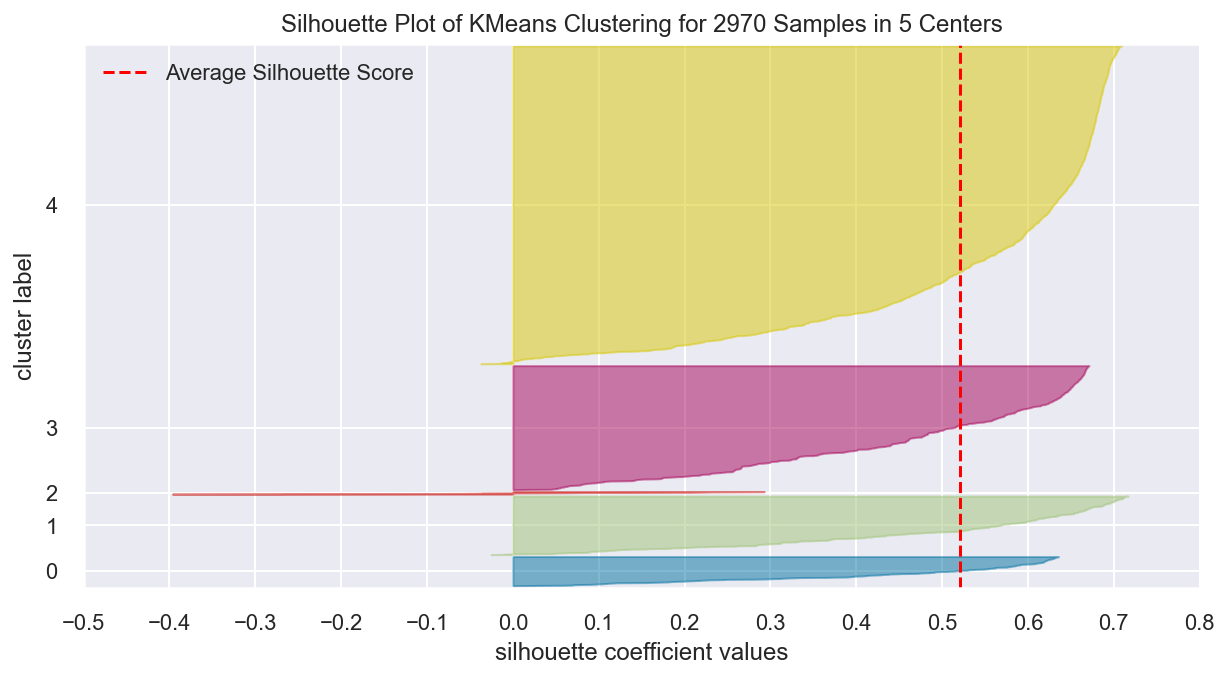

In [236]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( df8 )
visualizer.finalize()

## 9.2. 2D plot

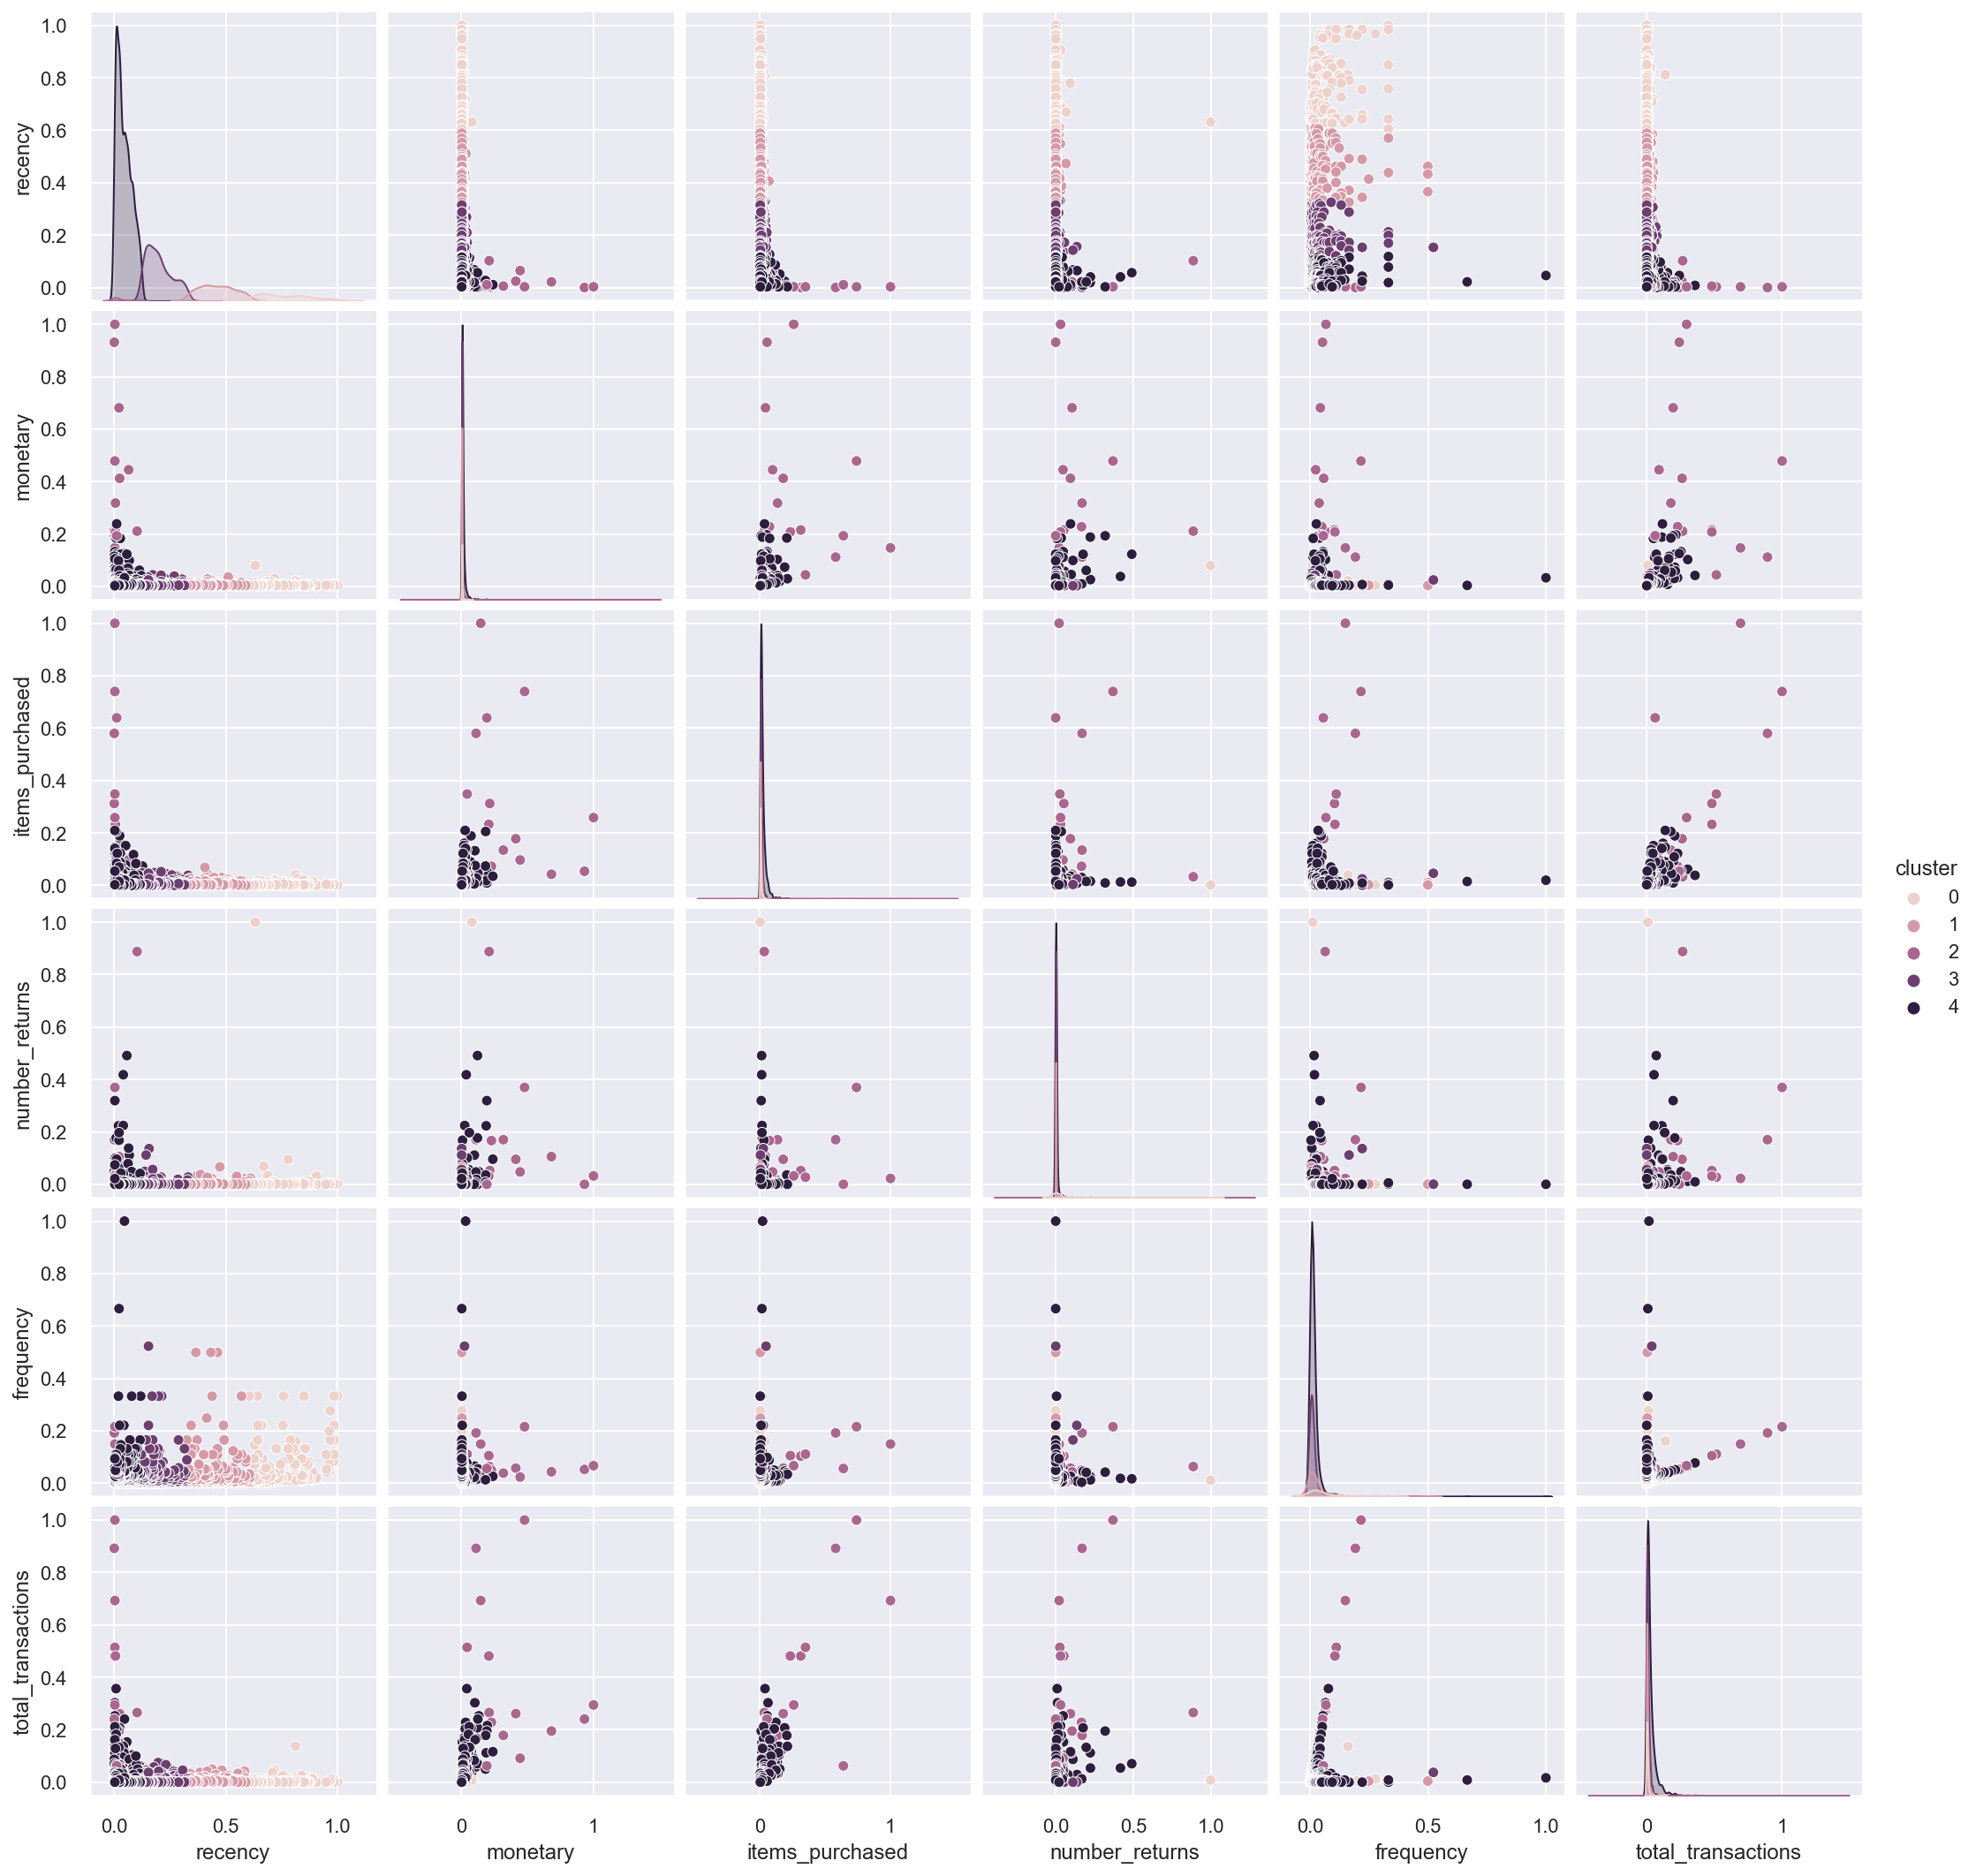

In [237]:
df_viz = df9.copy()
sns.pairplot( df_viz , hue='cluster' );

## 9.3. UMAP

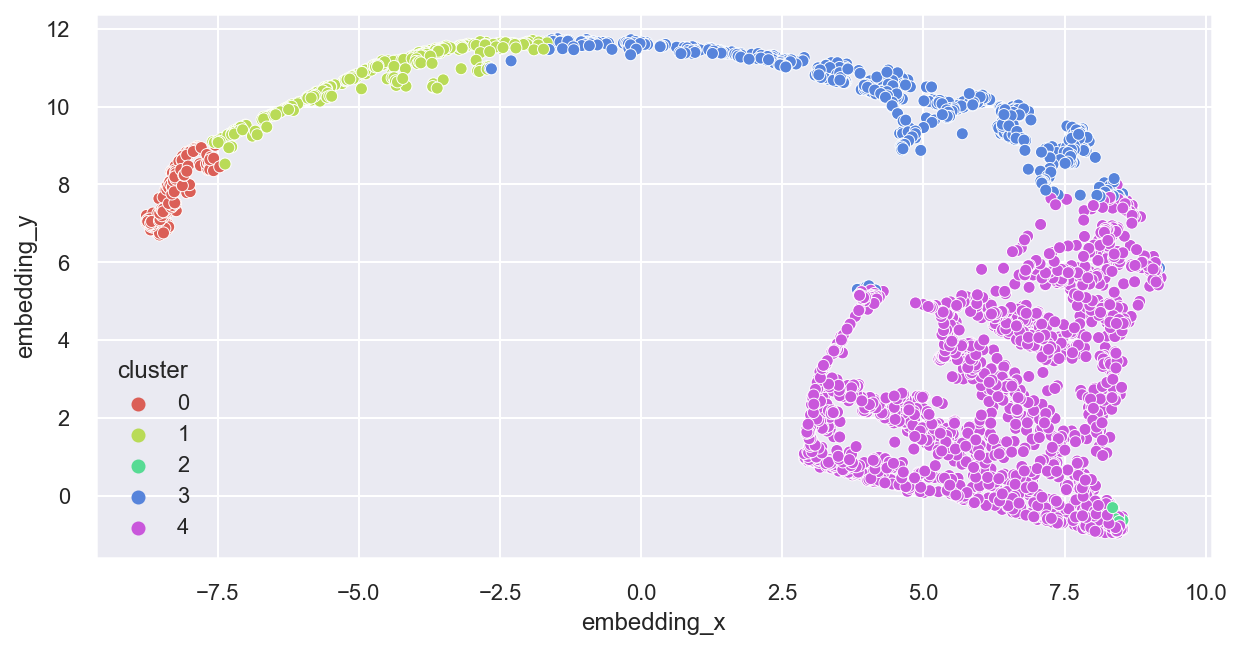

In [238]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( df8 )

# embedding 
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP 
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', 
                 palette = sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data = df_viz );

# 10.0. CLUSTER INSIGHTS

In [247]:
cols_insights = [  'customer_id', 'recency', 'monetary', 'items_purchased', 'number_returns', 'frequency', 'total_transactions' ]

df10 = df4[ cols_insights ].copy()
df10['cluster'] = df9['cluster'].copy()

## 10.1. Cluster Profile

In [249]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Number of customers
n_customers = df10[['customer_id','cluster']].groupby( 'cluster' ).count().reset_index()

# Name
n_customers['name'] = n_customers['cluster'].apply( lambda x: 'PRIVATE' if x == 2 else
                                                              'Platinum' if x== 4 else
                                                              'Gold' if x == 3 else
                                                              'Silver' if x == 1 else
                                                              'Standard' )

# Customer Perc
n_customers['percentage'] = 100 * ( n_customers['customer_id'] / n_customers['customer_id'].sum() )

# Avg recency
avg_recency = df10[['recency','cluster']].groupby( 'cluster' ).mean().reset_index()
n_customers = pd.merge( n_customers, avg_recency, on='cluster', how='left' )

# Avg monetary
avg_monetary = df10[['monetary','cluster']].groupby( 'cluster' ).median().reset_index()
n_customers = pd.merge( n_customers, avg_monetary, on='cluster', how='left' )

# Avg items purchased
avg_items_purchased = df10[['cluster','items_purchased']].groupby( 'cluster' ).median().reset_index()
n_customers = pd.merge( n_customers, avg_items_purchased, on='cluster', how='left' )

# Avg number of returns
avg_n_returns = df10[['cluster','number_returns']].groupby( 'cluster' ).median().reset_index()
n_customers = pd.merge( n_customers, avg_n_returns, on='cluster', how='left' )

# Avg number frequency
avg_frequency = df10[['cluster','frequency']].groupby( 'cluster' ).mean().reset_index()
n_customers = pd.merge( n_customers, avg_frequency, on='cluster', how='left' )

# Avg transactions
avg_transactions = df10[['cluster','total_transactions']].groupby( 'cluster' ).mean().reset_index()
n_customers = pd.merge( n_customers, avg_transactions, on='cluster', how='left' )

# Sort values
n_customers = n_customers.sort_values( 'monetary', ascending=False )
n_customers.columns = [ 'cluster', 'customer_id', 'name', 'percentage', 'avg_recency', 'avg_monetary', 
                        'avg_items_purchased', 'avg_number_returns',
                        'avg_frequency', 'avg_transactions' ]
n_customers

,cluster,customer_id,name,percentage,avg_recency,avg_monetary,avg_items_purchased,avg_number_returns,avg_frequency,avg_transactions
2,2,15,PRIVATE,0.51,6.27,62924.10,1857.00,474.00,0.27,96.47
4,4,1772,Platinum,59.66,16.23,1440.13,96.00,1.00,0.05,8.14
3,3,692,Gold,23.30,74.70,889.99,51.00,-0.00,0.05,4.15
1,1,327,Silver,11.01,171.14,592.88,31.00,-0.00,0.09,3.33
0,0,164,Standard,5.52,283.10,388.88,22.00,2.00,0.19,2.96


## 10.2. Business Hypothesis

**H1**: The Private cluster customers represent 20% of purchase volume per item.

**H2**: The Private cluster customers represent 10% of total revenue.

**H3**: The Private cluster customers have a average number of returns below the average of the total database.

**H4**: The Private Cluster customers max recency it's less than the total database mean.

**H5**: The Private Cluster customers represents 15% of the total transactions.

### H1: The Private cluster customers represent 20% of purchase volume per item.
**FALSE**. They represent only 10% of purchase volume per item.

In [277]:
df_items_private = df10.loc[ df10['cluster'] == 2, 'items_purchased' ].sum()
df_items_total = df10.loc[ :, 'items_purchased' ].sum()

print( 'Private percentage: {:.2f}%'.format( 100 * df_items_private / df_items_total) )

Private percentage: 10.10%


### H2: The Private cluster customers represent 10% of total revenue.
**TRUE**. They represent 20% of the total revenue.

In [278]:
df_monetary_private = df10.loc[ df10['cluster'] == 2, 'monetary' ].sum()
df_monetary_total = df10.loc[ :, 'monetary' ].sum()

print( 'Private percentage: {:.2f}%'.format( 100 * df_monetary_private / df_monetary_total) )

Private percentage: 20.09%


###  H3: The Private cluster customers have a median number of returns below the median of the total database.
**FALSE**. They return 1359.35% times more.

In [279]:
df_returns_insiders = df10.loc[ df10['cluster'] == 2, 'number_returns' ].median()
df_returns_total = df10.loc[ :, 'number_returns' ].mean()

print( 'Private percentage: {:.2f}%'.format( 100 * df_returns_insiders / df_returns_total) )

Private percentage: 1359.35%


### H4: The Private Cluster customers max recency it's less than the total database mean.
**TRUE**. The Private Cluster max recency it's 38% smaller than the total database mean.

In [283]:
max_recency_private = df10.loc[ df10['cluster'] == 2, 'recency' ].max()
recency_total_database = df10['recency'].mean()

print( 'Private max recency {}'.format( max_recency_private ) )
print( 'Total database mean recency {}'.format( np.round( recency_total_database, 0 ) ) )
print( 'Privates max recency in relation with total database mean recency : {:.2f}%'.format( 100 * ( max_recency_private / recency_total_database ) - 100 ) )

Private max recency 38
Total database mean recency 62.0
Privates max recency in relation with total database mean recency : -38.31%


### H5: The Private Cluster customers represents 15% of the total transactions.
**FALSE**. They only represent 7.12 of the total transactions.

In [289]:
private_total_transactions = df10.loc[ df10['cluster'] == 2, 'total_transactions' ].sum()
database_total_transactions = df10['total_transactions'].sum()
print( 'Private percentage: {:.2f}%'.format( 100 * ( private_total_transactions / database_total_transactions ) ) )

Private percentage: 7.12%


## 10.3. Business Report

### How many customers the group will have?

**15.**

### What's the main characteristics of those customers?

- Percentage in relation with database: **0.51%**
- Average Recency: **6.27 days until last purchase**
- Average Revenue: **$62.924,10**
- Median number of items purchased: **1857 items**
- Median number of returns: **474 items**
- Average frequency: **0.27 purchases per day**
- Average number of transactions: **96.47**

### What's the percentage of contribution in revenue from the Private customers?

**20%**

### What's the conditions for a person be elegible for the Privates?

In [309]:
df_privates_monetary = df10.loc[ df10['cluster'] == 2, 'monetary' ]
df_privates_items = df10.loc[ df10['cluster'] == 2, 'items_purchased' ]
df_privates_frequency = df10.loc[ df10['cluster'] == 2, 'frequency' ]

# Bootstrap
monetary_interval = st.t.interval( alpha = 0.95,
                                   df    = len( df_privates_monetary ) - 1,
                                   loc   = np.mean( df_privates_monetary ),
                                   scale = st.sem( df_privates_monetary ) )

items_interval = st.t.interval( alpha = 0.95,
                                   df    = len( df_privates_items ) - 1,
                                   loc   = np.mean( df_privates_items ),
                                   scale = st.sem( df_privates_items ) )

frequency_interval = st.t.interval( alpha = 0.95,
                                   df    = len( df_privates_frequency ) - 1,
                                   loc   = np.mean( df_privates_frequency ),
                                   scale = st.sem( df_privates_frequency ) )

print( 'Monetary Interval: {}'.format(monetary_interval) )
print( 'Items interval: {}'.format(items_interval) )
print( 'Frequency interval: {}'.format(frequency_interval) )

Monetary Interval: (59120.231176823676, 149018.8528231763)
Items interval: (1210.1717302499003, 3810.8949364167665)
Frequency interval: (0.1756497183785281, 0.3661651738534553)


The conditions are be in this streak for two consecutive months:
    
- Revenue: **59.120,23 - 149.018,85 dollars**
- Number of items purchased: **1210 - 3810**
- Frequency: **0.17 - 0.36**

### What's the conditions for a person be removed from the Privates?

**Be outside the eligible streak or break the streak for three consecutive months**

### What actions the Marketing Team can realize to increase the revenue? 

They can give cumulative benefits for the three best groups. So the most important group ( Private ) will have access to all benefits of the two below plus more exclusive ones.

This would estimulate the Private group to continue on the company and the hierarchically smaller ones to consume more and more frequently in order to progress and gain more and more exclusive benefits.

**Benefits:**

**Private Group:**

- Runs for a trip in the end of the year.
- Prioritary access to new products and personalized offers and recomendations.
- Unlimited access to free shipping and fast delivery of millions of items.
- Sistema de Pontuação: os clientes podem ganhar pontos simplesmente fazendo o cadastro, assim como fazendo aniversário, indicando amigos, deixando uma avaliação ou seguindo a empresa nas redes sociais.

**Platinum Group:**

- Unlimited access to free shipping and fast delivery of millions of items.
- Scoring System: Customers can earn points by signing up, as well as on their birthday date, referring friends, writing a review or following the company on social media.

**Gold Group:**

- Scoring System: Customers can earn points by signing up, as well as on their birthday date, referring friends, writing a review or following the company on social media.